In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import oscovida as ov
import numpy as np

In [3]:
ov.clear_cache()

In [4]:
data = ov.fetch_data_germany()

Please be patient - downloading data from https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data ...
Completed downloading 2113499 rows in 92.1 seconds.


In [5]:
sorted(data.index)[-1]

Timestamp('2021-07-25 00:00:00')

In [6]:
data.tail()

FID  IdBundesland Bundesland            Landkreis  \
date                                                                
2021-05-14  2113495            16  Thüringen  LK Altenburger Land   
2021-05-18  2113496            16  Thüringen  LK Altenburger Land   
2021-05-21  2113497            16  Thüringen  LK Altenburger Land   
2021-06-11  2113498            16  Thüringen  LK Altenburger Land   
2021-07-05  2113499            16  Thüringen  LK Altenburger Land   

           Altersgruppe Geschlecht  AnzahlFall  AnzahlTodesfall  \
date                                                              
2021-05-14         A80+          W           2                0   
2021-05-18         A80+          W           1                0   
2021-05-21         A80+          W           1                0   
2021-06-11         A80+          W           1                0   
2021-07-05         A80+          W           1                0   

                     Meldedatum  IdLandkreis             Datenstand  \
date                                                                  
2021-05-14  2021/05/14 00:00:00        16077  26.07.2021, 00:00 Uhr   
2021-05-18  2021/05/18 00:00:00        16077  26.07.2021, 00:00 Uhr   
2021-05-21  2021/05/21 00:00:00        16077  26.07.2021, 00:00 Uhr   
2021-06-11  2021/06/11 00:00:00        16077  26.07.2021, 00:00 Uhr   
2021-07-05  2021/07/05 00:00:00        16077  26.07.2021, 00:00 Uhr   

            NeuerFall  NeuerTodesfall             Refdatum  NeuGenesen  \
date                                                                     
2021-05-14          0              -9  2021/05/14 00:00:00           0   
2021-05-18          0              -9  2021/05/18 00:00:00           0   
2021-05-21          0              -9  2021/05/06 00:00:00           0   
2021-06-11          0              -9  2021/06/11 00:00:00           0   
2021-07-05          0              -9  2021/07/05 00:00:00           0   

            AnzahlGenesen  IstErkrankungsbeginn      Altersgruppe2  
date                                                                
2021-05-14              2                     0  Nicht übermittelt  
2021-05-18              1                     0  Nicht übermittelt  
2021-05-21              1                     1  Nicht übermittelt  
2021-06-11              1                     0  Nicht übermittelt  
2021-07-05              1                     0  Nicht übermittelt

<AxesSubplot:xlabel='date'>

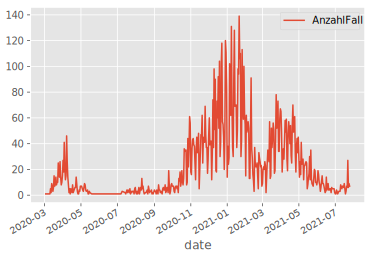

In [7]:
df4 = data.groupby(["Landkreis", "date"]).agg({'AnzahlFall': 'sum'})
df4.loc["LK Pinneberg"].plot()

In [8]:
df4.loc["LK Pinneberg"].sum()

AnzahlFall    10721
dtype: int64

In [9]:
total_infections = df4.unstack().sum().sum()
int(total_infections)

3756828

In [16]:
def rki_compute_weekly_incidence() -> pd.DataFrame:
    """ Returns DataFrame with datetime objects with 1-week spacing as index,
    and each column corresponds to one Landkreis. The values are the 7-day incidence 
    per 100,000 for each Landkreis.
    
    The first line may refer to less than a full week (best to drop that).
    """
    ignore = ["Städteregion Aachen"]
    
    data = ov.fetch_data_germany()
    # sum cases over different dates (for all LK)
    daily = data.groupby(["Landkreis", "date"]).agg({'AnzahlFall': 'sum'})
    
    # sum cases in weeks:
    weekly = daily.unstack().T.droplevel(0).resample("7D").sum()
    
    # the next solution is nicer in that we get complete weeks at the end of the table:
    # source: https://github.com/pandas-dev/pandas/issues/7049#issuecomment-276390475
    weekly = (daily.unstack().T.droplevel(0)).groupby(
        pd.Grouper(freq='W-MON', closed='right', label='left')).sum()
    
    # get population numbers into pops (can be done faster no doubt)
    pops = []
    index = []
    for lk in weekly.T.index:
        if lk in ignore:
            print(f"ignoring {lk}")
            continue
        index.append(lk)
        p = ov.population(country="Germany", subregion=lk)
        pops.append(p)
        # print(f" {lk} -> {int(p)}")
    pops_vec = pd.Series(data=pops, index=index)
        
    # compute incidence
    incidence = (weekly / pops_vec * 100000).T
    
    return incidence
    
incidence = rki_compute_weekly_incidence()

ignoring Städteregion Aachen


In [17]:
def test_rki_compute_weekly_incidence():
    x = rki_compute_weekly_incidence()
    
    # compare with manual calculation for Pinneberg:
    data = ov.fetch_data_germany()
    
    df4 = data.groupby(["Landkreis", "date"]).agg({'AnzahlFall': 'sum'})
    
    pinneberg_population = ov.population(country="Germany", subregion="LK Pinneberg")
    
    pinneberg7d = df4.unstack().loc["LK Pinneberg"].droplevel(0).resample("7D").sum() 

    pinneberg_incidence = pinneberg7d / pinneberg_population * 100000

    deviation = (pinneberg_incidence.sum() - x.loc["LK Pinneberg"].sum()) * pinneberg_population / 100000
    print (deviation)  # in multiples of infections, should only have numeric deviations
    assert  abs(deviation) < 1e-10
    
test_rki_compute_weekly_incidence()
    

ignoring Städteregion Aachen
0.0


In [18]:
incidence.loc["LK Pinneberg"].sum() * ov.population(
    country="Germany", subregion="LK Pinneberg") / 100000

10721.0

# Visualisation attempts

In [21]:
!pip install xarray

     |████████████████████████████████| 827 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/Users/fangohr/.pyenv/versions/3.9.0/bin/python3.9 -m pip install --upgrade pip' command.


In [22]:
i2 = incidence.to_xarray()

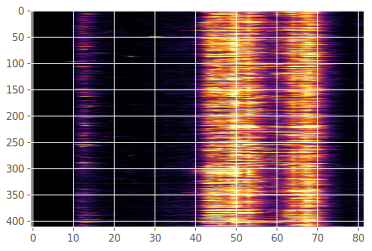

In [23]:
fig, ax = plt.subplots(1)
import matplotlib.colors
ax.imshow(incidence.to_numpy(), aspect='auto', interpolation="none", vmin=0, vmax=200,
          cmap=plt.cm.get_cmap("inferno"))

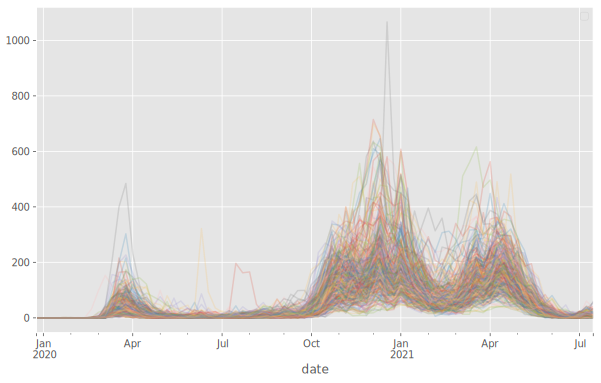

In [24]:
fig, ax = plt.subplots(1, figsize=(10, 6))
incidence.T.plot(ax=ax, alpha=0.2)
ax.legend("")
#ax.set_ylim((-400, 400))

## Compute change from week to week (negative is good!)

(-400.0, 400.0)

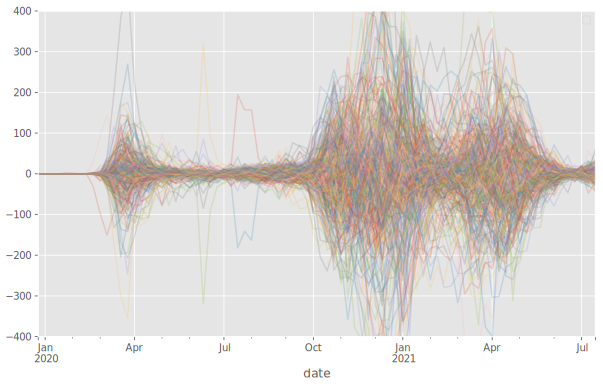

In [25]:
change = incidence.diff()
fig, ax = plt.subplots(1, figsize=(10, 6))
change.T.plot(ax=ax, alpha=0.2)
ax.legend("")
ax.set_ylim((-400, 400))

# Classify according to growing or shrinking land kreis

<ipython-input-26-aebe3e5a7909>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  change_hist = change.hist(ax=ax)


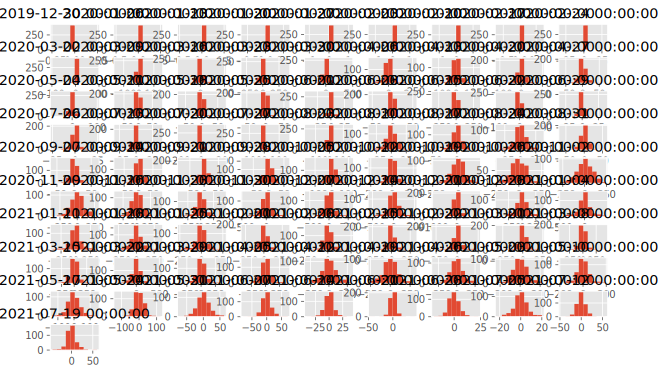

In [26]:
fig, ax = plt.subplots(1, figsize=(10, 6))
change_hist = change.hist(ax=ax)

# Example to understand the Grouper thing:

In [27]:
df = pd.DataFrame(pd.date_range('2016-01-29', '2016-02-29').rename('dt'))
df['val'] = 1
df.resample('7D', on='dt').val.sum()


dt
2016-01-29    7
2016-02-05    7
2016-02-12    7
2016-02-19    7
2016-02-26    4
Freq: 7D, Name: val, dtype: int64

In [28]:
a = df.groupby(pd.Grouper(key='dt',freq='W-MON', closed='left', label='left'))['val'].sum()
a

dt
2016-01-25    3
2016-02-01    7
2016-02-08    7
2016-02-15    7
2016-02-22    7
2016-02-29    1
Freq: W-MON, Name: val, dtype: int64

In [29]:
df.groupby(pd.Grouper(key='dt',freq='W-MON', closed='right', label='left'))['val'].sum()

dt
2016-01-25    4
2016-02-01    7
2016-02-08    7
2016-02-15    7
2016-02-22    7
Freq: W-MON, Name: val, dtype: int64

The above is the desired behaviour: at the end of the table, we have full weeks. We can skip the first week, which may not have 7 full days and thus be inaccurate.

In [30]:
# original solution:
df4.unstack().T.droplevel(0).resample("7D").sum()

Landkreis   LK Ahrweiler  LK Aichach-Friedberg  LK Alb-Donau-Kreis  \
date                                                                 
2020-01-02           0.0                   0.0                 0.0   
2020-01-09           0.0                   0.0                 0.0   
2020-01-16           0.0                   0.0                 0.0   
2020-01-23           0.0                   0.0                 0.0   
2020-01-30           0.0                   0.0                 0.0   
...                  ...                   ...                 ...   
2021-06-24          11.0                   2.0                 4.0   
2021-07-01           1.0                   3.0                20.0   
2021-07-08           4.0                   6.0                19.0   
2021-07-15          11.0                  43.0                15.0   
2021-07-22          15.0                  11.0                 9.0   

Landkreis   LK Altenburger Land  LK Altenkirchen  LK Altmarkkreis Salzwedel  \
date                                                                          
2020-01-02                  0.0              0.0                        0.0   
2020-01-09                  0.0              0.0                        0.0   
2020-01-16                  0.0              0.0                        0.0   
2020-01-23                  0.0              0.0                        0.0   
2020-01-30                  0.0              0.0                        0.0   
...                         ...              ...                        ...   
2021-06-24                  6.0              5.0                        3.0   
2021-07-01                  9.0              1.0                        0.0   
2021-07-08                 12.0              7.0                        2.0   
2021-07-15                  4.0              5.0                        0.0   
2021-07-22                  4.0              3.0                        0.0   

Landkreis   LK Altötting  LK Alzey-Worms  LK Amberg-Sulzbach  LK Ammerland  \
date                                                                         
2020-01-02           0.0             0.0                 0.0           0.0   
2020-01-09           0.0             0.0                 0.0           0.0   
2020-01-16           0.0             0.0                 0.0           0.0   
2020-01-23           0.0             0.0                 0.0           0.0   
2020-01-30           0.0             0.0                 0.0           0.0   
...                  ...             ...                 ...           ...   
2021-06-24           3.0             7.0                 0.0           3.0   
2021-07-01           8.0            20.0                 3.0           1.0   
2021-07-08           7.0            13.0                 8.0           5.0   
2021-07-15          16.0            23.0                12.0           9.0   
2021-07-22           1.0             5.0                 6.0           5.0   

Landkreis   ...  SK Weiden i.d.OPf.  SK Weimar  SK Wiesbaden  \
date        ...                                                
2020-01-02  ...                 0.0        0.0           0.0   
2020-01-09  ...                 0.0        0.0           0.0   
2020-01-16  ...                 0.0        0.0           0.0   
2020-01-23  ...                 0.0        0.0           0.0   
2020-01-30  ...                 0.0        0.0           0.0   
...         ...                 ...        ...           ...   
2021-06-24  ...                 1.0        2.0          22.0   
2021-07-01  ...                 0.0        3.0          18.0   
2021-07-08  ...                 1.0        0.0          62.0   
2021-07-15  ...                 3.0        0.0          80.0   
2021-07-22  ...                 1.0        1.0          36.0   

Landkreis   SK Wilhelmshaven  SK Wolfsburg  SK Worms  SK Wuppertal  \
date                                                                 
2020-01-02               0.0           0.0       0.0           0.0   
202

In [31]:
# using the Grouper command:

In [32]:
(df4.unstack().T.droplevel(0)).groupby(pd.Grouper(freq='W-MON', closed='right', label='left')).sum().sum()

Landkreis
LK Ahrweiler             4508.0
LK Aichach-Friedberg     5242.0
LK Alb-Donau-Kreis       8874.0
LK Altenburger Land      6913.0
LK Altenkirchen          4946.0
                         ...   
SK Worms                 4251.0
SK Wuppertal            20320.0
SK Würzburg              4617.0
SK Zweibrücken            868.0
Städteregion Aachen     26924.0
Length: 412, dtype: float64

# Histograms

In [56]:
x = incidence.T.loc["2020-04-20"]

In [57]:
incidence.T.index

DatetimeIndex(['2019-12-30', '2020-01-06', '2020-01-13', '2020-01-20',
               '2020-01-27', '2020-02-03', '2020-02-10', '2020-02-17',
               '2020-02-24', '2020-03-02', '2020-03-09', '2020-03-16',
               '2020-03-23', '2020-03-30', '2020-04-06', '2020-04-13',
               '2020-04-20', '2020-04-27', '2020-05-04', '2020-05-11',
               '2020-05-18', '2020-05-25', '2020-06-01', '2020-06-08',
               '2020-06-15', '2020-06-22', '2020-06-29', '2020-07-06',
               '2020-07-13', '2020-07-20', '2020-07-27', '2020-08-03',
               '2020-08-10', '2020-08-17', '2020-08-24', '2020-08-31',
               '2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28',
               '2020-10-05', '2020-10-12', '2020-10-19', '2020-10-26',
               '2020-11-02', '2020-11-09', '2020-11-16', '2020-11-23',
               '2020-11-30', '2020-12-07', '2020-12-14', '2020-12-21',
               '2020-12-28', '2021-01-04', '2021-01-11', '2021-01-18',
      

In [40]:
# compute week of the year to place histogram
week_of_the_year = [x.week for x in incidence.T.index[:]]
week_of_the_year_date = [x.strftime('%Y-%m-%d') for x in incidence.T.index[:]]

In [41]:
# compute bins for histograms

data_max_value = int(incidence.max().max())
bins_max_value = round(data_max_value+0.5)
bins_max_value = 600
print(f"Maximum value is {data_max_value})")
bins_width = 20
nbins = bins_max_value // bins_width + 1
print(f"Using {nbins} bins")
# equidistant bins
bins0 = np.linspace(0, nbins * bins_width, nbins + 1)
# add a bin for zero to 1 at the beginning
bins1 = [0] + list(bins0)
bins1[1] = 1
assert bins1[0] == 0
assert bins1[1] == 1
assert bins1[2] == bins_width


bins = bins1
# bins = bins0

# for later: add large boundary at right
assert bins[-1] > bins_max_value
# needed for histogram command
# bins_with_right_edge = list(bins)+[bins[-1] + bins_width]
bins_with_right_edge = list(bins)+[data_max_value + 1]
bins_with_right_edge

Maximum value is 1066)
Using 31 bins


[0,
 1,
 20.0,
 40.0,
 60.0,
 80.0,
 100.0,
 120.0,
 140.0,
 160.0,
 180.0,
 200.0,
 220.0,
 240.0,
 260.0,
 280.0,
 300.0,
 320.0,
 340.0,
 360.0,
 380.0,
 400.0,
 420.0,
 440.0,
 460.0,
 480.0,
 500.0,
 520.0,
 540.0,
 560.0,
 580.0,
 600.0,
 620.0,
 1067]

In [42]:

# suitable colours for histogram
def my_colours(n, alpha=0.1):
    import matplotlib
    #colours = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, n), alpha=alpha)
    #colours = matplotlib.pyplot.cm.RdYlGn(np.linspace(0, 1, n), alpha=alpha)
    colours = list(reversed(matplotlib.pyplot.cm.autumn(np.linspace(0, 1, n), alpha=alpha)))
    # first colour green
    colours[0] = [0, 1, 0, 1.0 + 0*alpha]
 
    return colours

# print(my_colours(50))

found 82 data sets
 week 0: sum(counts)=411

 week 1: sum(counts)=411

 week 2: sum(counts)=411

 week 3: sum(counts)=411

 week 4: sum(counts)=411

 week 5: sum(counts)=411

 week 6: sum(counts)=411

 week 7: sum(counts)=411

 week 8: sum(counts)=411

 week 9: sum(counts)=411

 week 10: sum(counts)=411

 week 11: sum(counts)=411

 week 12: sum(counts)=411

 week 13: sum(counts)=411

 week 14: sum(counts)=411

 week 15: sum(counts)=411

 week 16: sum(counts)=411

 week 17: sum(counts)=411

 week 18: sum(counts)=411

 week 19: sum(counts)=411

 week 20: sum(counts)=411

 week 21: sum(counts)=411

 week 22: sum(counts)=411

 week 23: sum(counts)=411

 week 24: sum(counts)=411

 week 25: sum(counts)=411

 week 26: sum(counts)=411

 week 27: sum(counts)=411

 week 28: sum(counts)=411

 week 29: sum(counts)=411

 week 30: sum(counts)=411

 week 31: sum(counts)=411

 week 32: sum(counts)=411

 week 33: sum(counts)=411

 week 34: sum(counts)=411

 week 35: sum(counts)=411

 week 36: sum(count

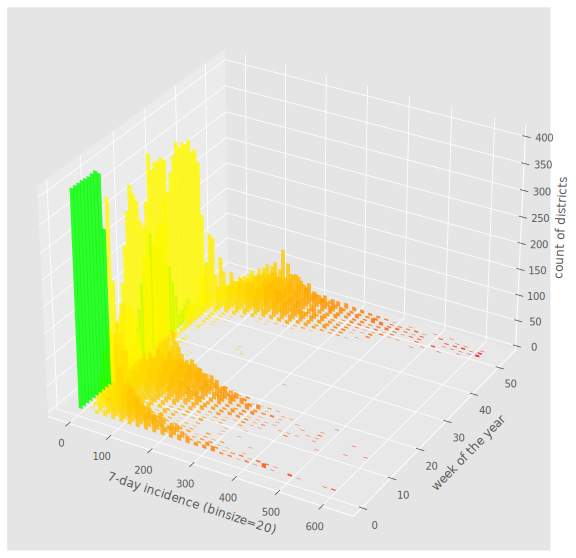

In [43]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
n = len(week_of_the_year)
print(f"found {n} data sets")
last_n_weeks = len(week_of_the_year_date)

# gather results in matrix
m_i = 0
m = np.zeros(shape=(last_n_weeks, len(bins)))

for c, z, i in zip(my_colours(last_n_weeks), week_of_the_year[-last_n_weeks:], range(n-last_n_weeks, n)):
    # print(z, i, m_i, incidence.iloc[i, :].max())
    xs = bins
    count, bins_ = np.histogram(incidence.T.iloc[i, :], bins=bins_with_right_edge)
    m[m_i, :] = count[:]
    m_i += 1
    if sum(count) != 412:
        print(f" week {i}: sum(counts)={sum(count)}\n")
    ys = count

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    cs = my_colours(len(xs))
    # cs[0] = 'c'
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8, width=0.5*bins_width)

ax.set_xlabel(f'7-day incidence (binsize={bins_width})')
ax.set_zlabel('count of districts')
ax.set_ylabel('week of the year')

plt.show()

In [44]:
m.shape

(82, 33)

In [45]:
len(bins)

33

In [46]:
# Compute colour for histogram 
mcolourmask = m > 0
mcolour = np.zeros_like(m)
mcolour[mcolourmask] = 1
# use nans for entries with 0 -> transparent
mcolour[~mcolourmask] = np.nan

# use incidence for other values
import numpy.linalg
mcolor = numpy.multiply(mcolour, bins)

# Compute alpha

alpha_max = 20
m_alpha = np.zeros_like(m)
m_alpha[m < alpha_max] = m[m < alpha_max]/alpha_max 
m_alpha[m >= alpha_max] = 1
# m_alpha[m == 0] = 0 


In [47]:
m_alpha.max(), m_alpha.min()

(1.0, 0.0)

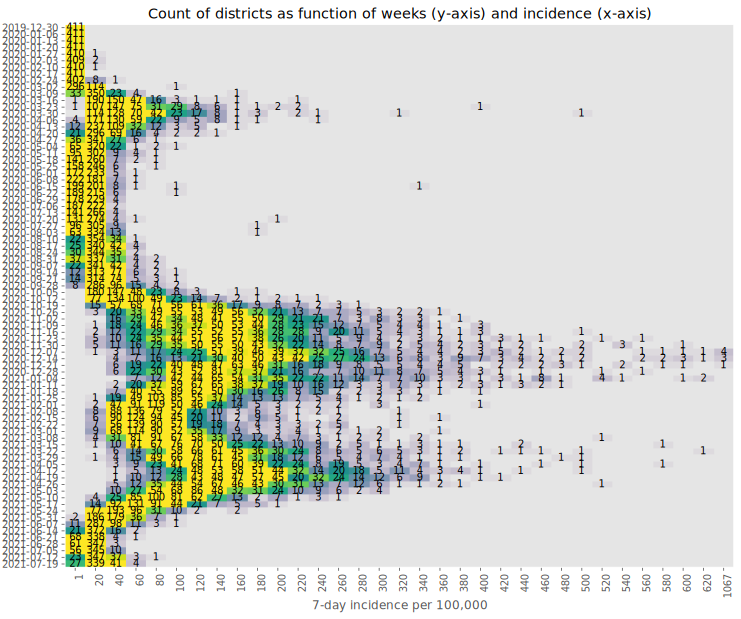

In [48]:
# row labels (77, -> weeks or dates)


row_label = week_of_the_year_date

#vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
#              "potato", "wheat", "barley"]

# column labels: (skip first boundary)
col_label = list(map(int, bins_with_right_edge[1:]))

#farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
#           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = m

#fig, ax = plt.subplots(figsize=(16, 20))

fig, ax = plt.subplots(figsize=(12, 10))

# idea: 
# use second matrix for choice of colours. Colour gets redder as number increases

#im = ax.imshow(mcolor, aspect='auto', #cmap=plt.cm.get_cmap("inferno")
#               cmap=plt.cm.get_cmap("RdYlGn_r"), 
#               alpha=m_alpha, vmax=200)

im = ax.imshow(m, aspect='auto', #cmap=plt.cm.get_cmap("inferno")
               # cmap=plt.cm.get_cmap("Greys"), 
               vmax=40, alpha=m_alpha)


# We want to show all ticks...
ax.set_xticks(np.arange(len(col_label)))
ax.set_yticks(np.arange(len(row_label)))
# ... and label them with the respective list entries
ax.set_xticklabels(col_label)
ax.set_yticklabels(row_label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
if True:
    for i in range(len(row_label)):
        for j in range(len(col_label)):
            # print(f"{i} {j} {m.shape}")
            if harvest[i,j] > 0:
                #text = ax.text(j, i, str(int(harvest[i, j])),
                #               ha="center", va="center", color="k",
                #               alpha=min(m_alpha[i, j]*3, 1))
                text = ax.text(j, i, str(int(harvest[i, j])),
                               ha="center", va="center", color="k")
                               #alpha=min(m_alpha[i, j]*3, 1))




ax.grid(False)
ax.set_xlabel("7-day incidence per 100,000")
ax.set_title("Count of districts as function of weeks (y-axis) and incidence (x-axis)");
fig.savefig('incidence-count-time.pdf')

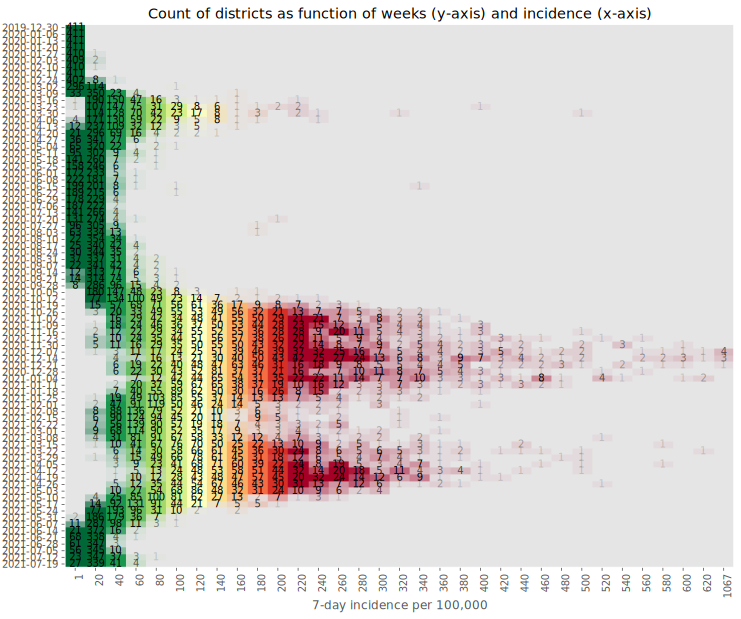

In [49]:
# row labels (77, -> weeks or dates)


row_label = week_of_the_year_date

#vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
#              "potato", "wheat", "barley"]

# column labels: (skip first boundary)
col_label = list(map(int, bins_with_right_edge[1:]))

#farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
#           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = m

#fig, ax = plt.subplots(figsize=(16, 20))

fig, ax = plt.subplots(figsize=(12, 10))

# idea: 
# use second matrix for choice of colours. Colour gets redder as number increases

im = ax.imshow(mcolor, aspect='auto', #cmap=plt.cm.get_cmap("inferno")
               cmap=plt.cm.get_cmap("RdYlGn_r"), 
               alpha=m_alpha, vmax=200)



# We want to show all ticks...
ax.set_xticks(np.arange(len(col_label)))
ax.set_yticks(np.arange(len(row_label)))
# ... and label them with the respective list entries
ax.set_xticklabels(col_label)
ax.set_yticklabels(row_label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
if True:
    for i in range(len(row_label)):
        for j in range(len(col_label)):
            # print(f"{i} {j} {m.shape}")
            if harvest[i,j] > 0:
                text = ax.text(j, i, str(int(harvest[i, j])),
                               ha="center", va="center", color="k",
                               alpha=min(m_alpha[i, j]*3, 1))
                



ax.grid(False)
ax.set_xlabel("7-day incidence per 100,000")
ax.set_title("Count of districts as function of weeks (y-axis) and incidence (x-axis)");
fig.savefig('incidence-count-time.pdf')

In [50]:
g2 = data.set_index(pd.to_datetime(data['Meldedatum']))
g2.index.name = 'date'
g3 = g2.groupby('date').agg('sum')
cases_rki_mel = g3["AnzahlFall"].groupby('date').agg('sum').cumsum()
deaths_rki_mel = g3["AnzahlTodesfall"].groupby('date').agg('sum').cumsum()
pop_germany = ov.get_population().loc["Germany"]['population']

<AxesSubplot:xlabel='date'>

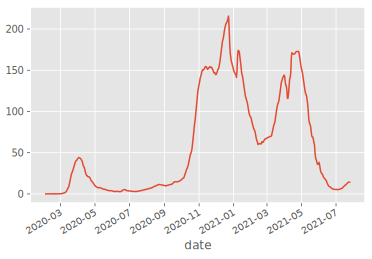

In [51]:
incidence_germany = cases_rki_mel.diff().rolling(7).mean() / pop_germany * 100000
(incidence_germany*7).plot()

In [52]:
inc_ger_weekly = incidence_germany.resample('W').sum()
assert len(inc_ger_weekly) == len(week_of_the_year_date)
len(inc_ger_weekly)

82

In [53]:
len(week_of_the_year_date)

82

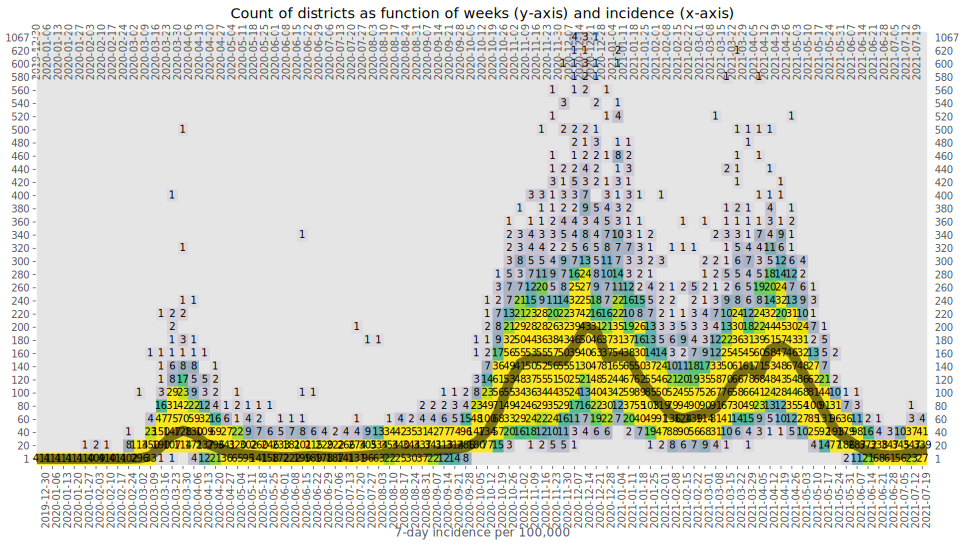

In [54]:
# row labels (77, -> weeks or dates)
col_label = week_of_the_year_date

row_label = list(map(int, bins_with_right_edge[1:]))

#fig, ax = plt.subplots(figsize=(16, 20))

fig, ax = plt.subplots(figsize=(16, 8))

# idea: 
# use second matrix for choice of colours. Colour gets redder as number increases

#im = ax.imshow(mcolor.T, aspect='auto', #cmap=plt.cm.get_cmap("inferno")
#               cmap=plt.cm.get_cmap("RdYlGn_r"), 
#               alpha=m_alpha.T, vmax=200, origin='lower')

im = ax.imshow(m.T, aspect='auto', #cmap=plt.cm.get_cmap("inferno") 
               vmax=25, origin='lower', alpha=m_alpha.T )




ax.tick_params(labeltop=True, labelright=True)

# We want to show all ticks...
ax.set_xticks(np.arange(len(col_label)))
ax.set_yticks(np.arange(len(row_label)))
# ... and label them with the respective list entries
ax.set_xticklabels(col_label)
ax.set_yticklabels(row_label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
if True:
    for i in range(len(row_label)):
        for j in range(len(col_label)):
            # print(f"{i} {j} {m.shape}")
            if harvest.T[i,j] > 0:
                text = ax.text(j, i, str(int(harvest.T[i, j])),
                               ha="center", va="center", color="k",
                               )#alpha=min(m_alpha.T[i, j]*3, 1))
                

ax.plot(range(len(inc_ger_weekly)), inc_ger_weekly.values / bins_width, '-k', linewidth=10, alpha=0.5)
ax.grid(False)
ax.set_xlabel("7-day incidence per 100,000")
ax.set_title("Count of districts as function of weeks (y-axis) and incidence (x-axis)");
fig.savefig('incidence-count-time2.pdf')

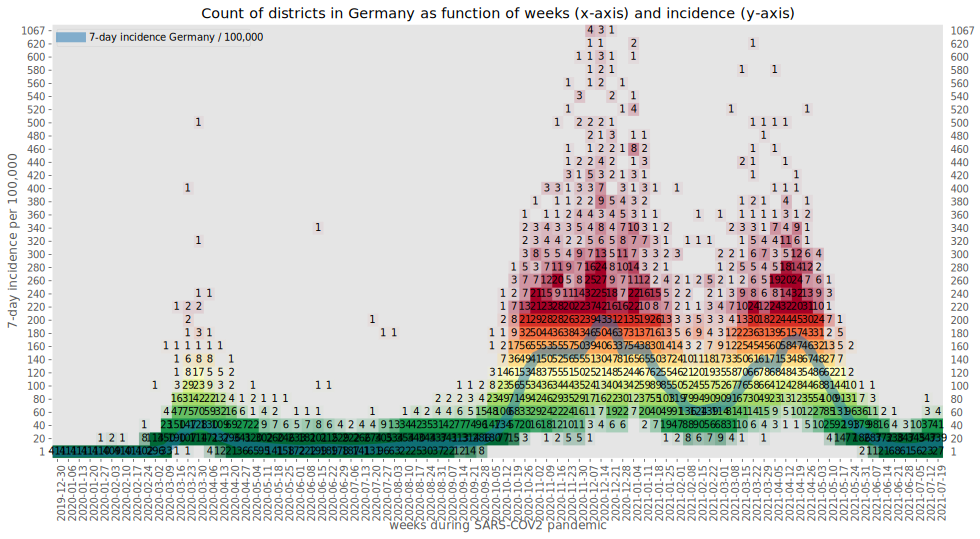

In [55]:
# row labels (77, -> weeks or dates)
col_label = week_of_the_year_date

row_label = list(map(int, bins_with_right_edge[1:]))

#fig, ax = plt.subplots(figsize=(16, 20))

fig, ax = plt.subplots(figsize=(16, 8))

# idea: 
# use second matrix for choice of colours. Colour gets redder as number increases

im = ax.imshow(mcolor.T, aspect='auto', #cmap=plt.cm.get_cmap("inferno")
               cmap=plt.cm.get_cmap("RdYlGn_r"), 
               alpha=m_alpha.T, vmax=200, origin='lower')

#im = ax.imshow(m.T, aspect='auto', #cmap=plt.cm.get_cmap("inferno") 
#               vmax=25, origin='lower', alpha=m_alpha.T )




ax.tick_params(labeltop=False, labelright=True)

# We want to show all ticks...
ax.set_xticks(np.arange(len(col_label)))
ax.set_yticks(np.arange(len(row_label)))
# ... and label them with the respective list entries
ax.set_xticklabels(col_label)
ax.set_yticklabels(row_label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
if True:
    for i in range(len(row_label)):
        for j in range(len(col_label)):
            # print(f"{i} {j} {m.shape}")
            if harvest.T[i,j] > 0:
                text = ax.text(j, i, str(int(harvest.T[i, j])),
                               ha="center", va="center", color="k",
                               )#alpha=min(m_alpha.T[i, j]*3, 1))
                

ax.plot(range(len(inc_ger_weekly)), inc_ger_weekly.values / bins_width, '-', color='tab:blue', linewidth=10, alpha=0.5, 
        label="7-day incidence Germany / 100,000")
ax.grid(False)
ax.set_ylabel("7-day incidence per 100,000")
ax.set_xlabel("weeks during SARS-COV2 pandemic")
ax.set_title("Count of districts in Germany as function of weeks (x-axis) and incidence (y-axis)");
ax.legend(loc='upper left')
fig.savefig('2021-incidence-count-districts-germany.pdf')
fig.savefig('2021-incidence-count-districts-germany.png', dpi=300)